In [1]:
filename = 'warmerBucketInstructions.mkv'

In [ ]:
# ffmpeg -i input_file.wav -ar 16000 -ac 1 -sample_fmt s16 output_file.wav
# command = f'ffmpeg -i {filename}{ext} -ar 16000 -ac 1 -sample_fmt s16 {filename}.wav'

In [ ]:
# command

In [ ]:
# !{command}

In [ ]:
# %pip install whispercpp
# %pip install git+https://github.com/AIWintermuteAI/whispercpp.git -vv

In [ ]:
# %pip install build

In [ ]:
# from whispercpp import Whisper

In [ ]:
# whisper = Whisper.from_pretrained("tiny.en")

In [ ]:
# %pip install ffmpeg-python
# %pip install numpy

In [2]:
import ffmpeg
import numpy as np
import numpy

In [ ]:
# try:
#     y, _ = (
#         ffmpeg.input(filename, threads=0)
#         .output("-", format="s16le", acodec="pcm_s16le", ac=1, ar=16000)
#         .run(
#             cmd=["ffmpeg", "-nostdin"], capture_stdout=True, capture_stderr=True
#         )
#     )
# except ffmpeg.Error as e:
#     raise RuntimeError(f"Failed to load audio: {e.stderr.decode()}") from e

# arr = np.frombuffer(y, np.int16).flatten().astype(np.float32) / 32768.0

# whisper.transcribe(arr)

In [ ]:
# whisper.transcribe_from_file("warmerBucketInstructions.wav")

In [ ]:
# from whispercpp import api

In [ ]:
# %pip install openai-whisper

In [3]:
import whisper
model = whisper.load_model("tiny.en")
transcript = model.transcribe(
    word_timestamps=True,
    audio="warmerBucketInstructions.wav"
)
for segment in transcript['segments']:
    print(''.join(f"{word['word']}[{word['start']}/{word['end']}]" 
                    for word in segment['words']))

/opt/homebrew/anaconda3/envs/py10/lib/python3.10/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 Instruction[4.2600000000000025/4.980000000000001] manual,[4.980000000000001/5.7] warmer[6.08/6.08] bucket.[6.08/7.26]
 Description.[10.46/10.86]
 The[12.0/12.2] appearance[12.2/12.6] adopts[12.6/13.24] the[13.24/13.5] pearl[13.5/13.78] white,[13.78/14.28] gray,[14.34/14.76] wood[15.16/15.2] grain[15.2/15.54] and[15.54/15.78] other[15.78/16.04] patterns.[16.04/16.64]
 Light[17.52/17.78] weight[17.78/18.14] and[18.14/18.38] can[18.38/18.62] move[18.62/18.92] at[18.92/19.26] home.[19.26/19.7]
 The[20.64/20.82] lid[20.82/21.12] can[21.12/21.4] be[21.4/21.68] separated.[21.68/22.2]
 Simple[23.4/23.6] and[23.6/23.94] clear[23.94/24.28] indicator[24.28/24.68] light[24.68/25.34] can[25.34/26.34] be[26.34/26.64] placed[26.64/27.0] smoothly[27.0/27.66] on[27.66/28.06] ceramic[28.06/28.36] tiles,[28.36/28.92] porcelain,[29.48/29.82]
 ceramics[29.82/30.62] and[30.62/30.9] other[30.9/31.22] floors.[31.22/31.82]
 Important[33.56/33.56] safeguards.[33.56/34.3]
 The[35.74/35.82] product[35.82/36.1] i

In [ ]:
# transcript

In [ ]:
# transcript['text']

In [ ]:
# %pip install ollama

In [4]:
import ollama
summary = ollama.chat(model='llama3', messages=[
  {
    'role': 'user',
    'content': f'''Summarize the following transcript:\n {transcript['text']}''',
  },
])

In [5]:
print(summary['message']['content'])

This is an instruction manual for a warmer bucket appliance, intended for household use only. The manual provides important safety precautions and guidelines for using the product.

**Safety Precautions:**

* Use the product only as intended.
* Check the item carefully before use.
* Do not switch on the heater with defects or damaged cord.
* Plug in the item only to an AC source (120V, 60Hz).
* Only use grounded sockets and avoid non-standard power supplies.
* Keep hands away from wet surfaces and do not touch the heater with wet hands.

**Usage:**

* The product can be placed on ceramic tiles, porcelain, ceramics, and other floors.
* It is recommended to heat pure cotton materials only.
* Do not leave the heater unattended.
* Always plug out the heater after use before cleaning or finding defects.

**Cleaning:**

* Wait for the heater to cool down before cleaning.
* Use a soft wet cloth to wipe the product. Avoid abrasives and solvents.
* Remove dust from the surface regularly.
* Do n

In [6]:
# with open('transcript.txt', 'w+') as file:
#   file.write(str(transcript))

# with open('summary.txt', 'w+') as file:
#   file.write(str(summary))


In [ ]:
# summaryLen = len(summary['message']['content'].split())
# transcriptLen = len(transcript['text'].split())
# lastWord = transcript['segments'][-1]['words'][-1]
# originalSeconds = lastWord['end']

# summaryLen, transcriptLen, lastWord, originalSeconds

In [ ]:
# %pip install torch
# %pip install transformers
# %pip install einops

In [7]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

sentences = ['search_query: What is TSNE?', 'search_query: Who is Laurens van der Maaten?']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, safe_serialization=True)
model.eval()

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# + matryoshka_dim = 512

with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# + embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
# + embeddings = embeddings[:, :matryoshka_dim]
embeddings = F.normalize(embeddings, p=2, dim=1)
print(embeddings)

/opt/homebrew/anaconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<All keys matched successfully>


tensor([[-0.0039,  0.0538, -0.1763,  ..., -0.0453, -0.0359, -0.0250],
        [-0.0066,  0.0046, -0.1858,  ..., -0.0284, -0.0296,  0.0129]])


In [ ]:
# np.float_ = np.float64
# import chromadb
# client = chromadb.Client()
# collection = client.create_collection("sample_collection")

# # Add docs to the collection. Can also update and delete. Row-based API coming soon!
# collection.add(
#     documents=["This is document1", "This is document2"], # we embed for you, or bring your own
#     metadatas=[{"source": "notion"}, {"source": "google-docs"}], # filter on arbitrary metadata!
#     ids=["doc1", "doc2"], # must be unique for each doc 
# )

# results = collection.query(
#     query_texts=["This is a query document"],
#     n_results=2,
#     # where={"metadata_field": "is_equal_to_this"}, # optional filter
#     # where_document={"$contains":"search_string"}  # optional filter
# )

In [ ]:
# %pip install pgvector
# %pip install psycopg
# %pip install -U sentence_transformers

In [ ]:
# from pgvector.psycopg import register_vector
# import psycopg
# from sentence_transformers import SentenceTransformer

# conn = psycopg.connect(dbname='vec_test_db', autocommit=True, user="evanburnette", password="postgres")

# conn.execute('CREATE EXTENSION IF NOT EXISTS vector')
# register_vector(conn)

# conn.execute('DROP TABLE IF EXISTS documents')
# conn.execute('CREATE TABLE documents (id bigserial PRIMARY KEY, content text, embedding vector(384))')
# conn.execute("CREATE INDEX ON documents USING GIN (to_tsvector('english', content))")

# sentences = [
#     'The dog is barking',
#     'The cat is purring',
#     'The bear is growling'
# ]
# model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# embeddings = model.encode(sentences)
# for content, embedding in zip(sentences, embeddings):
#     conn.execute('INSERT INTO documents (content, embedding) VALUES (%s, %s)', (content, embedding))

# sql = """
# WITH semantic_search AS (
#     SELECT id, RANK () OVER (ORDER BY embedding <=> %(embedding)s) AS rank
#     FROM documents
#     ORDER BY embedding <=> %(embedding)s
#     LIMIT 20
# ),
# keyword_search AS (
#     SELECT id, RANK () OVER (ORDER BY ts_rank_cd(to_tsvector('english', content), query) DESC)
#     FROM documents, plainto_tsquery('english', %(query)s) query
#     WHERE to_tsvector('english', content) @@ query
#     ORDER BY ts_rank_cd(to_tsvector('english', content), query) DESC
#     LIMIT 20
# )
# SELECT
#     COALESCE(semantic_search.id, keyword_search.id) AS id,
#     COALESCE(1.0 / (%(k)s + semantic_search.rank), 0.0) +
#     COALESCE(1.0 / (%(k)s + keyword_search.rank), 0.0) AS score
# FROM semantic_search
# FULL OUTER JOIN keyword_search ON semantic_search.id = keyword_search.id
# ORDER BY score DESC
# LIMIT 5
# """
# query = 'growling bear'
# embedding = model.encode(query)
# k = 60
# results = conn.execute(sql, {'query': query, 'embedding': embedding, 'k': k}).fetchall()
# for row in results:
#     print('document:', row[0], 'RRF score:', row[1])

In [9]:
# from pgvector.psycopg import register_vector
# import psycopg
from sentence_transformers import SentenceTransformer

# conn = psycopg.connect(dbname='vec_test_db', user="evanburnette", autocommit=True, password="postgres")

# conn.execute('CREATE EXTENSION IF NOT EXISTS vector')
# register_vector(conn)

# conn.execute('DROP TABLE IF EXISTS documents')
# conn.execute('CREATE TABLE documents (id bigserial PRIMARY KEY, content text, embedding vector(384))')

# input = [
#     'The dog is barking',
#     'The cat is purring',
#     'The bear is growling'
# ]

# embed_model = SentenceTransformer('all-MiniLM-L6-v2')
# embeddings = embed_model.encode(input)

# for content, embedding in zip(input, embeddings):
#     conn.execute('INSERT INTO documents (content, embedding) VALUES (%s, %s)', (content, embedding))

# document_id = 1
# target = conn.execute('SELECT content FROM documents WHERE id = %(id)s', {'id': document_id}).fetchall()
# neighbors = conn.execute('SELECT content FROM documents WHERE id != %(id)s ORDER BY embedding <=> (SELECT embedding FROM documents WHERE id = %(id)s) LIMIT 1', {'id': document_id}).fetchall()
# print(target)
# for neighbor in neighbors:
#     print(neighbor[0])

In [10]:
embed_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

/opt/homebrew/anaconda3/envs/py10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<All keys matched successfully>


In [34]:
summary_text = summary['message']['content']
# summary_text

In [33]:
import re
summary_lines = list(map(lambda x: x.strip().replace('* ', ''), filter(lambda x: x != '', re.split(r'\n', summary_text))))
# summary_lines

In [94]:
summary_embeds = embed_model.encode([line for line in summary_lines])
# assert np.linalg.norm(summary_embeds[0]) == 1, "embeds are not normalized!"

In [ ]:
# summary_embeds

In [35]:
# transcript['segments'][0]

In [18]:
# transcript_lines = list(map(lambda x: x.strip().replace('* ', ''), filter(lambda x: x != '', re.split(r'\.\s', transcript['text']))))
# transcript_embeds = [embed_model.encode(segment['text']) for segment in transcript['segments']]
transcript_embeds = embed_model.encode([segment['text'] for segment in transcript['segments']])
# transcript_embeds

In [ ]:
# transcript_embeds = [embed_model.encode(line) for line in transcript_lines]

In [36]:
# for each segment, create the phrase
# transcript['segments'][20]['words']

### Transcript data we want for our database
- Line text
- Line embed
- Line start and end times

In [20]:
import torch
import torch.nn.functional as F
summary_tensor = torch.FloatTensor(summary_embeds)
transcript_tensor = torch.FloatTensor(transcript_embeds)
summary_tensor.shape, transcript_tensor.shape

/var/folders/ww/2prrclfj731gmf182xddgx2m0000gn/T/ipykernel_21323/2769929972.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  summary_tensor = torch.FloatTensor(summary_embeds)


(torch.Size([22, 768]), torch.Size([96, 768]))

In [119]:
summary_norm = F.normalize(summary_tensor, p=2, dim=1)
transcript_norm = F.normalize(transcript_tensor, p=2, dim=1)

mask = torch.eye(transcript_norm.shape[0])
for idx, vec in enumerate(transcript_norm):
    if transcript['segments'][idx]['text'] == '':
        mask[idx][idx] = 0

# mask = torch.tensor(mask) @ torch.tensor(mask).transpose(1,0)

matches = (summary_norm @ transcript_norm.transpose(0,1)) @ mask
matches.shape, mask.shape
# matches = F.cosine_similarity(summary_tensor, transcript_tensor, dim=0)
# matches.shape

(torch.Size([22, 96]), torch.Size([96, 96]))

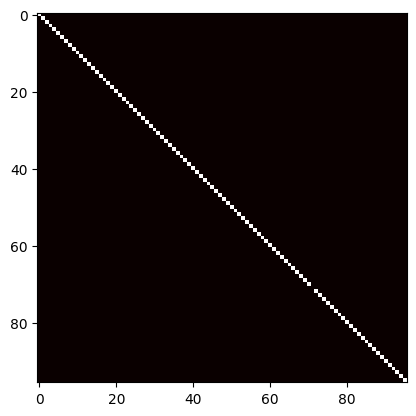

In [120]:
plt.imshow(mask, cmap='hot', interpolation='nearest')
plt.show()

In [121]:
# %pip install matplotlib
from matplotlib import pyplot as plt

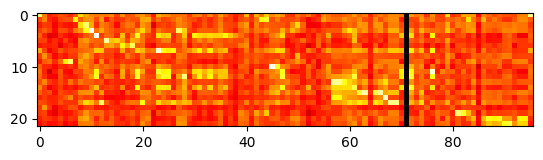

In [122]:
plt.imshow(matches, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.title('Matches heatmap')
plt.show()

In [65]:
def create_sweep_gaussian(height, width, sigma=1.0):
    # Create an empty tensor of the given size
    result = torch.zeros((height, width))
    
    # Define the sweep path starting indices for each row
    start_indices = torch.linspace(0, width - 1, steps=height).int()
    
    # Apply Gaussian emphasis across each row based on the start index
    for row in range(height):
        start_index = start_indices[row]
        for col in range(width):
            # Calculate the Gaussian emphasis using periodic boundary conditions
            # This creates a wrap-around effect from the end of the row to the beginning
            distance = (col - start_index)
            result[row, col] = torch.exp(-(distance**2) / (2 * sigma**2))
    
    return result

# Usage
height, width = matches.shape
sigma = 40.0  # Adjust sigma for how tightly you want the Gaussian to concentrate around the sweep
sweep_gaussian_tensor = create_sweep_gaussian(height, width, sigma)

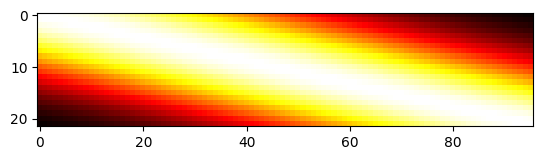

In [66]:
plt.imshow(sweep_gaussian_tensor, cmap="hot", interpolation="nearest")
plt.show()

In [67]:
modMatches = matches * sweep_gaussian_tensor
matchIdxs = modMatches.max(1)[1]
matchIdxs

tensor([ 0,  7,  9, 10, 11, 13, 18, 23, 50,  6, 45, 47, 61, 58, 61, 66, 67, 69,
        71, 81, 87, 91])

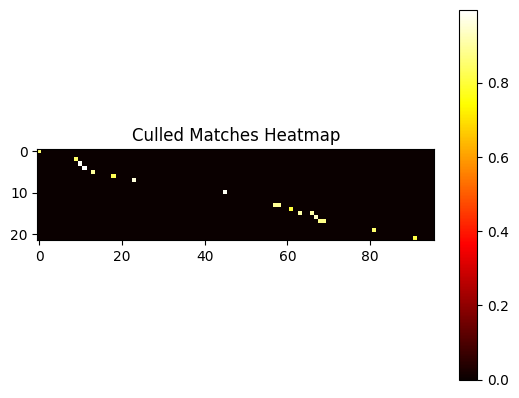

In [74]:
culledMatches = (modMatches > 0.8) * matches
culledMatches
plt.imshow(culledMatches, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Culled Matches Heatmap')
plt.show()

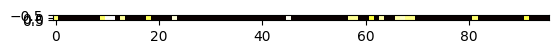

In [84]:
crushVec = torch.ones(1, culledMatches.shape[0])
crushedMatches = crushVec @ culledMatches
crushedMatches.shape
plt.imshow(crushedMatches, cmap='hot', interpolation='nearest')
plt.show()

In [89]:
crushedMatchSet = set()
for idx, match in enumerate(crushedMatches.squeeze()):
    if (match != 0):
        crushedMatchSet.add(idx)
crushedMatchSet

{0, 9, 10, 11, 13, 18, 23, 45, 57, 58, 61, 63, 66, 67, 68, 69, 81, 91}

In [71]:
summary_lines[10], transcript['segments'][6]['text']

('It is recommended to heat pure cotton materials only.',
 ' ceramics and other floors.')

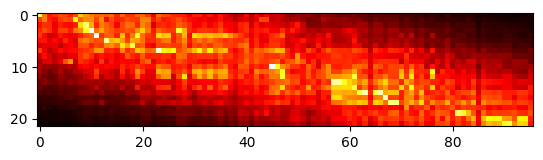

In [68]:
plt.imshow(modMatches, cmap="hot", interpolation="nearest")
plt.show()

In [123]:
# newSummary = [transcript['segments'][idx] for idx in matchIdxs]
newSummary = [transcript['segments'][idx] for idx in crushedMatchSet]
# newSummary
# '\n'.join(newSummary)

In [124]:
def extract_clip(input_file, start_time, end_time, output_file):
    (
        ffmpeg
        .input(input_file, ss=start_time, to=end_time)
        .output(output_file, codec="copy")  # Using codec="copy" to avoid re-encoding
        .run(capture_stdout=True, capture_stderr=True)
    )
clips = []
for idx, segment in enumerate(newSummary):
  clipName = f'clip{idx}.mkv'
  try:
      extract_clip(filename, segment['start'], segment['end'], clipName)
      clips.append(clipName)
  except:
      print(f'failed on {clipName}\n{segment}')

with open('file_list.txt', 'w+') as fileList:
  for clip in clips:
    fileList.write(f'file {clip}\n')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [125]:
# inputs = [ffmpeg.input(file) for file in clips]

# concatenated = ffmpeg.concat(*inputs, v=1, a=1).node
# output = ffmpeg.output(concatenated[0], concatenated[1], 'output.mp4')
# ffmpeg.run(output)

# concatenated = ffmpeg.concat(*inputs, v=1, a=1, unsafe=True)  # Added unsafe=True for files with different properties
# output = ffmpeg.output(concatenated, 'output.mp4')
# ffmpeg.run(output)

ffmpeg.input('file_list.txt', format='concat', safe=0)\
    .output('output.mkv')\
    .run()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidsta

(None, None)

In [ ]:
howto = ollama.chat(model='llama3', messages=[
  {
    'role': 'user',
    'content': f'''pytorch maximum along tensor axis. Code only please''',
  },
])
print(howto['message']['content'])